In [3]:
import os, random
from statistics import mean, correlation, stdev
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import networkx as nx
random.seed(2)

In [4]:
players_location = []
location_to_players = {}
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
for index, data in files.iterrows():
    for i in range(data.NUMBER_OF_PARTICIPANTS):
        players_location.append((index, i+1))
        location_to_players[(index, i+1)] = len(players_location) - 1

In [5]:
players_graph = nx.read_gml(os.path.join('comm-f2f-Resistance', 'embeddings.gml'), destringizer=int)
len(players_graph), players_graph.nodes()

(451,
 NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

## Player Simmilarity Metrics

Metrics from the player simmilarity graph.

In [351]:
players_binary_graph = nx.Graph()
sample_binary_graph = nx.erdos_renyi_graph(len(players_graph), p=0.5, seed=2)

In [352]:
for origin, neighbors in players_graph.adjacency():
    for neighbor, data in neighbors.items():
        # How we created the graph this keeps 50% of the edges
        if data['weight'] > 0.5:
            players_binary_graph.add_edge(neighbor, origin)


In [354]:
# Despite the fact that half of the edges are kept, the graph shows the existance of very dissimilar players
print(f'Graph diameter: {nx.diameter(players_binary_graph)}')
print(f'Expected diameter (if the graph was random): {nx.diameter(sample_binary_graph)}')

Graph diameter: 5
Expected diameter (if the graph was random): 2


In [ ]:
# Following the same logic, this comparison shows the existence of very simmilar players and the community structure
cliques = [*nx.find_cliques(players_binary_graph)]
len(cliques), mean(map(len, cliques)), max(map(len, cliques))

(14350, 117.52717770034843, 139)

In [355]:
# Comparison with a random graph
cliques = [*nx.find_cliques(sample_binary_graph)]
len(cliques), mean(map(len, cliques)), max(map(len, cliques))

(49025736, 8.06268366883875, 13)

In [330]:
betweenness_data = nx.betweenness_centrality(players_graph, weight='weight')
betweenness = pd.Series(betweenness_data)
betweenness.index = pd.Series([players_location[i] for i in betweenness.index])

# Top 10 players with highest betweenness centrality (most average players in terms of playstyle)
betweenness = betweenness.sort_values(ascending=False)
betweenness.head(10)

(49, 4)    0.170750
(34, 4)    0.165791
(4, 6)     0.000000
(53, 6)    0.000000
(53, 7)    0.000000
(53, 8)    0.000000
(54, 1)    0.000000
(54, 2)    0.000000
(54, 3)    0.000000
(54, 4)    0.000000
dtype: float64

In [335]:
important_players = betweenness[betweenness > 0]
print(f'Only {len(important_players)} central players out of {len(players_location)}')

Only 2 central players out of 451


In [ ]:
clustering_data = nx.clustering(players_graph, weight='weight')
clustering = pd.Series(clustering_data)
clustering.index = pd.Series([players_location[i] for i in clustering.index])

# Top 10 players with highest clustering coefficient (most average players in terms of playstyle)
clustering = clustering.sort_values(ascending=False)
clustering.head(10) # Very simmilar in value

(16, 2)    0.555722
(22, 5)    0.555698
(55, 7)    0.554838
(25, 7)    0.554788
(60, 5)    0.554195
(54, 8)    0.554065
(3, 3)     0.553978
(4, 5)     0.553596
(60, 7)    0.553549
(60, 1)    0.553372
dtype: float64

In [361]:
nx.average_clustering(players_binary_graph), nx.average_clustering(sample_binary_graph)

(0.8045219721078578, 0.4989325032289961)

In [ ]:
# Same idea as before
nx.transitivity(players_binary_graph), nx.transitivity(sample_binary_graph)

(0.7708871914091316, 0.4989237757436607)

In [366]:
eccentricity_data = [nx.eccentricity(players_binary_graph, node) for node in players_binary_graph.nodes()]
eccentricity_data_sample = [nx.eccentricity(sample_binary_graph, node) for node in sample_binary_graph.nodes()]
mean(eccentricity_data), mean(eccentricity_data_sample)

(3.3325942350332594, 2)

In [367]:
nx.average_shortest_path_length(players_binary_graph), nx.average_shortest_path_length(sample_binary_graph)

(1.625750184774575, 1.501029810298103)

## Game Metrics

Metrics from the games graphs.

### Games-wise metrics

Metrics regarding how games work out, independently of individual players.

In [6]:
files = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network_list.csv'))
games: list[pd.DataFrame] = []
for index, data in files.iterrows():
    game = pd.read_csv(os.path.join('comm-f2f-Resistance', 'network', f'network{index}_weighted.csv'))
    cols_to_drop = ['TIME']
    cols_to_drop.extend(game.columns[game.columns.str.match(r'P._TO_LAPTOP')])
    game.drop(columns=cols_to_drop, inplace=True)
    # 2 minute window for smoothing
    smoothed_df = game.rolling(window=120).mean().dropna().reset_index(drop=True)
    games.append(smoothed_df)
games

[      P1_TO_P1  P1_TO_P2  P1_TO_P3  P1_TO_P4  P1_TO_P5  P1_TO_P6  P1_TO_P7  \
 0          0.0  0.093650  0.224667  0.010033  0.084692  0.043967  0.457533   
 1          0.0  0.094267  0.227192  0.010208  0.085550  0.044175  0.458025   
 2          0.0  0.095333  0.228625  0.010450  0.086567  0.044758  0.458817   
 3          0.0  0.096642  0.230575  0.010567  0.087567  0.045408  0.459567   
 4          0.0  0.097517  0.231617  0.010658  0.088642  0.046000  0.460242   
 ...        ...       ...       ...       ...       ...       ...       ...   
 7199       0.0  0.105142  0.417392  0.008275  0.152550  0.023733  0.270875   
 7200       0.0  0.104400  0.415758  0.008075  0.152167  0.023183  0.274575   
 7201       0.0  0.104275  0.413892  0.007850  0.152142  0.022875  0.277242   
 7202       0.0  0.103775  0.412675  0.007608  0.151500  0.022492  0.280483   
 7203       0.0  0.103792  0.412258  0.007375  0.151625  0.022242  0.281317   
 
       P2_TO_P1  P2_TO_P2  P2_TO_P3  ...  P6_TO_P5

In [7]:
from math import sqrt
def create_graph_instance(row: pd.Series) -> nx.DiGraph:
    """Create a graph representing a moment in the game."""
    players = round(sqrt(len(row)))
    matrix = row.values.reshape(players, players)
    return nx.DiGraph(matrix)

def create_binary_graph_instance(row: pd.Series) -> nx.DiGraph:
    """Create a graph representing a moment in the game."""
    players = round(sqrt(len(row)))
    binary_row = row > row.median()
    matrix = binary_row.values.reshape(players, players)
    return nx.DiGraph(matrix)

from typing import Callable
# Python 3.12+ for the generic T, otherwise use:
# def calculate_metric(row: pd.Series, *, metric):
def calculate_metric[T](row: pd.Series, *, metric: Callable[[nx.DiGraph], T]) -> T:
    G = create_graph_instance(row)
    return metric(G)

def return_true(row):
    return True

games[0].apply(calculate_metric, axis=1, metric=return_true)

0       True
1       True
2       True
3       True
4       True
        ... 
7199    True
7200    True
7201    True
7202    True
7203    True
Length: 7204, dtype: bool

In [118]:
from statistics import mean
def extract_features(row):
    G = create_graph_instance(row)
    Gb = create_binary_graph_instance(row)
    return pd.Series({
        'avg_degree': sum(dict(G.degree(weight='weight')).values()) / G.number_of_nodes(),
        'clustering': nx.average_clustering(G, weight='weight'),
        'betweeness': mean(nx.betweenness_centrality(G, weight='weight').values()),
        'transitivity': nx.transitivity(Gb),
        'reciprocity': nx.reciprocity(Gb),
    })

games[4].apply(extract_features, axis=1)

,avg_degree,clustering,betweeness,transitivity,reciprocity
0,1.896485,0.190597,0.062500,0.774510,0.5625
1,1.899840,0.193275,0.062500,0.750000,0.5625
2,1.900140,0.195783,0.065476,0.750000,0.5625
3,1.900529,0.198233,0.065476,0.750000,0.5625
4,1.901058,0.199970,0.065476,0.750000,0.5625
...,...,...,...,...,...
7199,1.927596,0.313937,0.083333,0.730769,0.6875
7200,1.928056,0.306709,0.086310,0.725490,0.6250
7201,1.928671,0.302334,0.083333,0.725490,0.6250
7202,1.928648,0.297716,0.083333,0.725490,0.6250


In [ ]:
# Game-wise metrics
instances = pd.Series()
accum = pd.DataFrame()
for game in tqdm(games):
    instances = instances.add(pd.Series([True] * len(game)), fill_value=False)
    accum = accum.add(game.apply(extract_features, axis=1), fill_value=0)

100%|██████████| 62/62 [26:19<00:00, 25.48s/it]


In [ ]:
metrics = accum.div(instances, axis=0)

In [160]:
metrics.to_csv('metrics.csv', index=False)
metrics = pd.read_csv('metrics.csv')

array([<Axes: xlabel='Time', ylabel='Value'>,
       <Axes: xlabel='Time', ylabel='Value'>,
       <Axes: xlabel='Time', ylabel='Value'>,
       <Axes: xlabel='Time', ylabel='Value'>,
       <Axes: xlabel='Time', ylabel='Value'>], dtype=object)

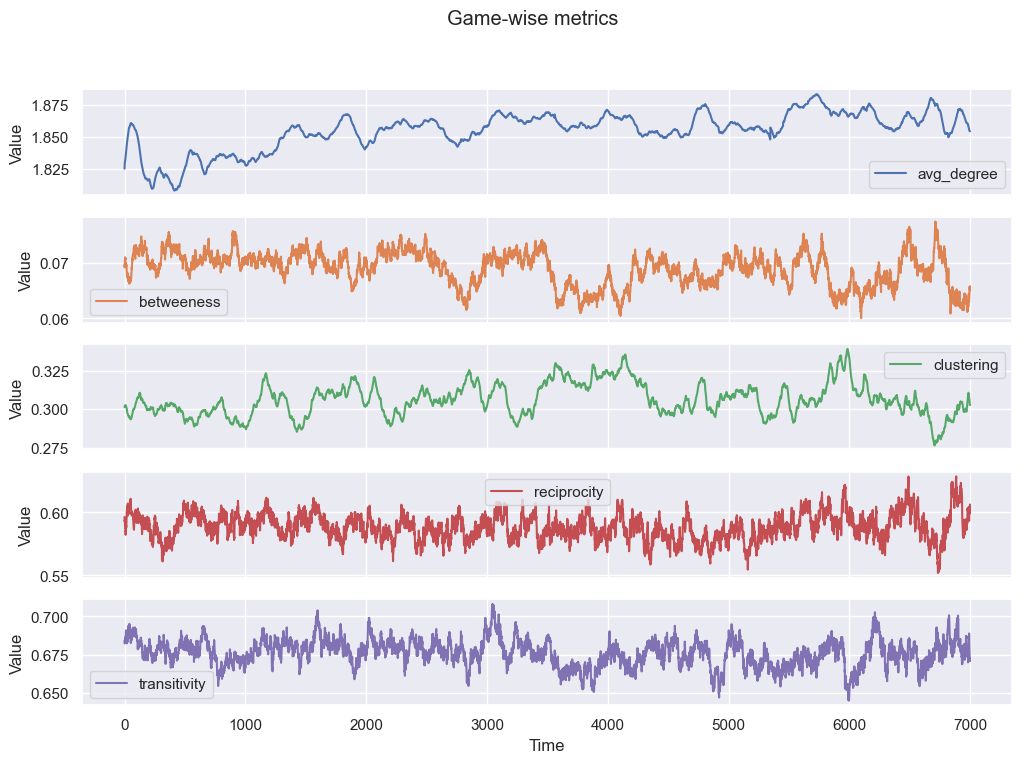

In [196]:
metrics[:7000].plot.line(figsize=(12, 8), title='Game-wise metrics', xlabel='Time', ylabel='Value', subplots=True)

Despite having been playing for more than two hours, players as a group still behave almost the same as they did at the beginning. Although it is a counter-intuitive result, the reason might lie on how the study was carried out.

### Players-wise Metrics

Metrics of how players act during games.

In [62]:
max_player_game = None
max_player = None
max_value = 0
for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    player, value = max(G.in_degree(weight='weight'), key=lambda x: x[1])
    if value > max_value:
        max_player_game = idx
        max_player = player
        max_value = value

print(f'Player {max_player + 1} (from game {max_player_game}) was the most attractive player with an average of players looking at them of {max_value:.2f} during the entirety game.')

Player 4 (from game 40) was the most attractive player with an average of players looking at them of 2.30 during the entirety game.


In [302]:
max_player_game = None
max_player = None
max_value = 0
for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    player, value = max(G.out_degree(weight='weight'), key=lambda x: x[1])
    if value > max_value:
        max_player_game = idx
        max_player = player
        max_value = value

print(f'Player {max_player + 1} (from game {max_player_game}) was the most social player maintaining an interactability of {max_value:.3f}.')

Player 7 (from game 30) was the most social player maintaining an interactability of 0.995.


In [303]:
min_player_game = None
min_player = None
min_value = float('inf')
for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    player, value = min(G.in_degree(weight='weight'), key=lambda x: x[1])
    if value < min_value:
        min_player_game = idx
        min_player = player
        min_value = value

print(f'Player {min_player + 1} (from game {min_player_game}) was the most subtle player with an average of players looking at them of {min_value:.3f} during the entirety game.')

Player 8 (from game 42) was the most subtle player with an average of players looking at them of 0.274 during the entirety game.


In [304]:
min_player_game = None
min_player = None
min_value = float('inf')
for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    player, value = min(G.out_degree(weight='weight'), key=lambda x: x[1])
    if value < min_value:
        min_player_game = idx
        min_player = player
        min_value = value

print(f'Player {min_player + 1} (from game {min_player_game}) was the least social player maintaining an interactability of {min_value:.3f}.')

Player 2 (from game 24) was the least social player maintaining an interactability of 0.711.


In [305]:
max_player_game = None
max_player = None
max_value = 0
for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    player, value = max(nx.betweenness_centrality(G, weight='weight').items(), key=lambda x: x[1])
    if value > max_value:
        max_player_game = idx
        max_player = player
        max_value = value

print(f'Player {max_player + 1} (from game {max_player_game}) was the most important player since he was the center of about {max_value:.2%} interactions.')

Player 6 (from game 43) was the most important player since he was the center of about 46.67% interactions.


Correlation: -0.17810972568248912


<Axes: >

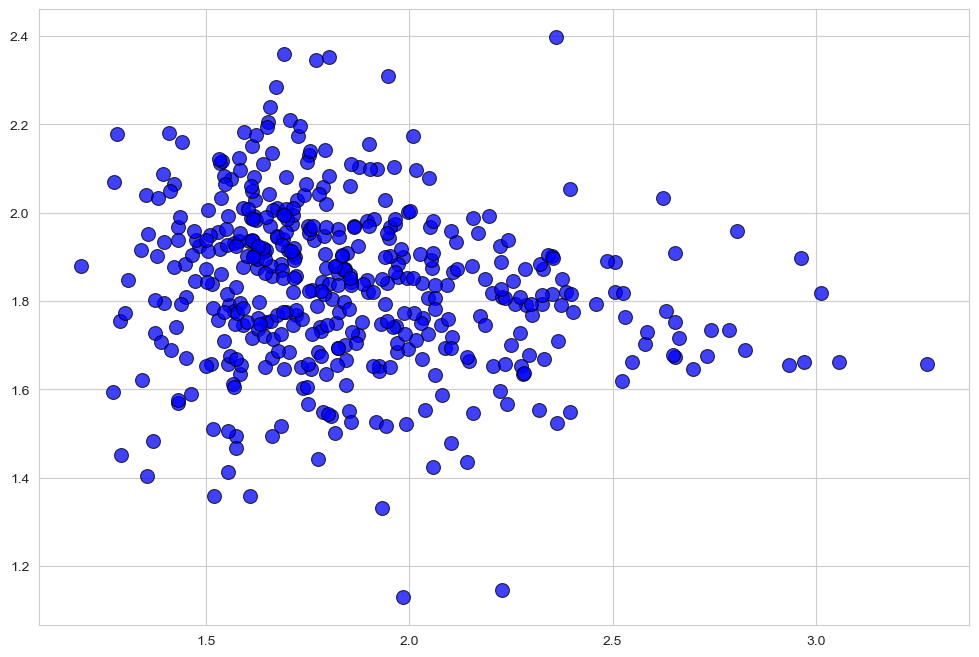

In [21]:
x = []
y = []
for _, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    degrees = G.degree(weight='weight')
    for node, degree in degrees:
        x.append(degree)
        avg_neighbor_degree = sum(
            degrees[neighbor]*G[node][neighbor]['weight']
            for neighbor in G.neighbors(node)
        )
        y.append(avg_neighbor_degree)
        

print(f'Correlation: {correlation(x,y)}')
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.scatterplot(x=x, y=y, alpha=0.75, s=100, color='blue', edgecolor='black')
# It is apparent that not necessarily most social players tend to interact with other more social players

## Community-wise Metrics

In [9]:
communities = nx.community.greedy_modularity_communities(players_graph, weight='weight', resolution=1.5, best_n=4)
[len(community) for community in communities]

[131, 130, 104, 86]

In [10]:
player_to_community = [None] * len(players_location)
for idx, community in enumerate(communities):
    for player in community:
        player_to_community[player] = idx

In [49]:
pd.set_option('future.no_silent_downcasting', True)
attributes_data = pd.DataFrame(
    columns=range(len(communities)),
    index=[
        'intra_community',
        'inter_community',
        'intra_community_count',
        'inter_community_count'
    ]
).fillna(0)

for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    
    # Intra-community
    for node in G.nodes():
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]

        weights = [
            data['weight']
            for _, v, data
            in G.out_edges(node, data=True)
            if community == player_to_community[location_to_players[(idx, v+1)]]
        ]
        if weights:
            attributes_data.at['intra_community', community] += mean(weights)
            attributes_data.at['intra_community_count', community] += 1

    # Inter-community
    for node in G.nodes():
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]

        weights = [
            data['weight']
            for _, v, data
            in G.out_edges(node, data=True)
            if community != player_to_community[location_to_players[(idx, v+1)]]
        ]
        if weights:
            attributes_data.at['inter_community', community] += mean(weights)
            attributes_data.at['inter_community_count', community] += 1

attributes_data.loc['intra_community', :] = attributes_data.loc['intra_community', :]\
    .div(attributes_data.loc['intra_community_count', :])
attributes_data.loc['inter_community', :] = attributes_data.loc['inter_community', :]\
    .div(attributes_data.loc['inter_community_count', :])
attributes = attributes_data.loc[['intra_community', 'inter_community'],:]
attributes.div(attributes.sum()).style.format('{:.2%}')
# According to the paper, deceivers actively avoid looking at each other

,0,1,2,3
intra_community,59.57%,37.30%,41.69%,59.30%
inter_community,40.43%,62.70%,58.31%,40.70%


In [56]:
pd.set_option('future.no_silent_downcasting', True)
properties = pd.DataFrame(
    columns=range(len(communities)),
    index=[
        'attention',
        'attractiveness',
        'inconsistency',
        'controversity',
        'focus',
    ]
).fillna(0)

for idx, game in enumerate(games):
    G = create_graph_instance(game.mean(axis='rows'))
    GV = create_graph_instance(game.std(axis='rows').div(game.mean(axis='rows')).fillna(0))
    # Attention
    for node, degree in G.out_degree(weight='weight'):
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]
        properties.at['attention', community] += degree

    # Attractiveness
    for node, degree in G.in_degree(weight='weight'):
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]
        properties.at['attractiveness', community] += degree

    # Inconsistency
    for node, degree in GV.in_degree(weight='weight'):
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]
        properties.at['inconsistency', community] += degree

    # Controverity
    for node in G.nodes():
        weights = [data['weight'] for _, _, data in G.in_edges(node, data=True)]
        controversity = stdev(weights) / mean(weights)
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]
        properties.at['controversity', community] += controversity
    
    # Focus
    for node in G.nodes():
        weights = [data['weight'] for _, _, data in G.out_edges(node, data=True)]
        controversity = stdev(weights) / mean(weights)
        player = location_to_players[(idx, node+1)]
        community = player_to_community[player]
        properties.at['focus', community] += controversity

        
properties = properties.div([len(community) for community in communities], axis=1)
properties.loc['reciprocity_multiplier', :] = attributes.loc['inter_community', :] / attributes.loc['intra_community', :]
properties
# According to the study, focus is one of the most significant.

,0,1,2,3
attention,0.933492,0.927343,0.914648,0.933828
attractiveness,1.07095,0.74859,0.808262,1.123304
inconsistency,2.985808,2.833093,2.624195,2.656348
controversity,0.306586,0.328404,0.346503,0.306339
focus,0.479614,0.486494,0.500533,0.507067
reciprocity_multiplier,0.678766,1.681253,1.398499,0.686468
